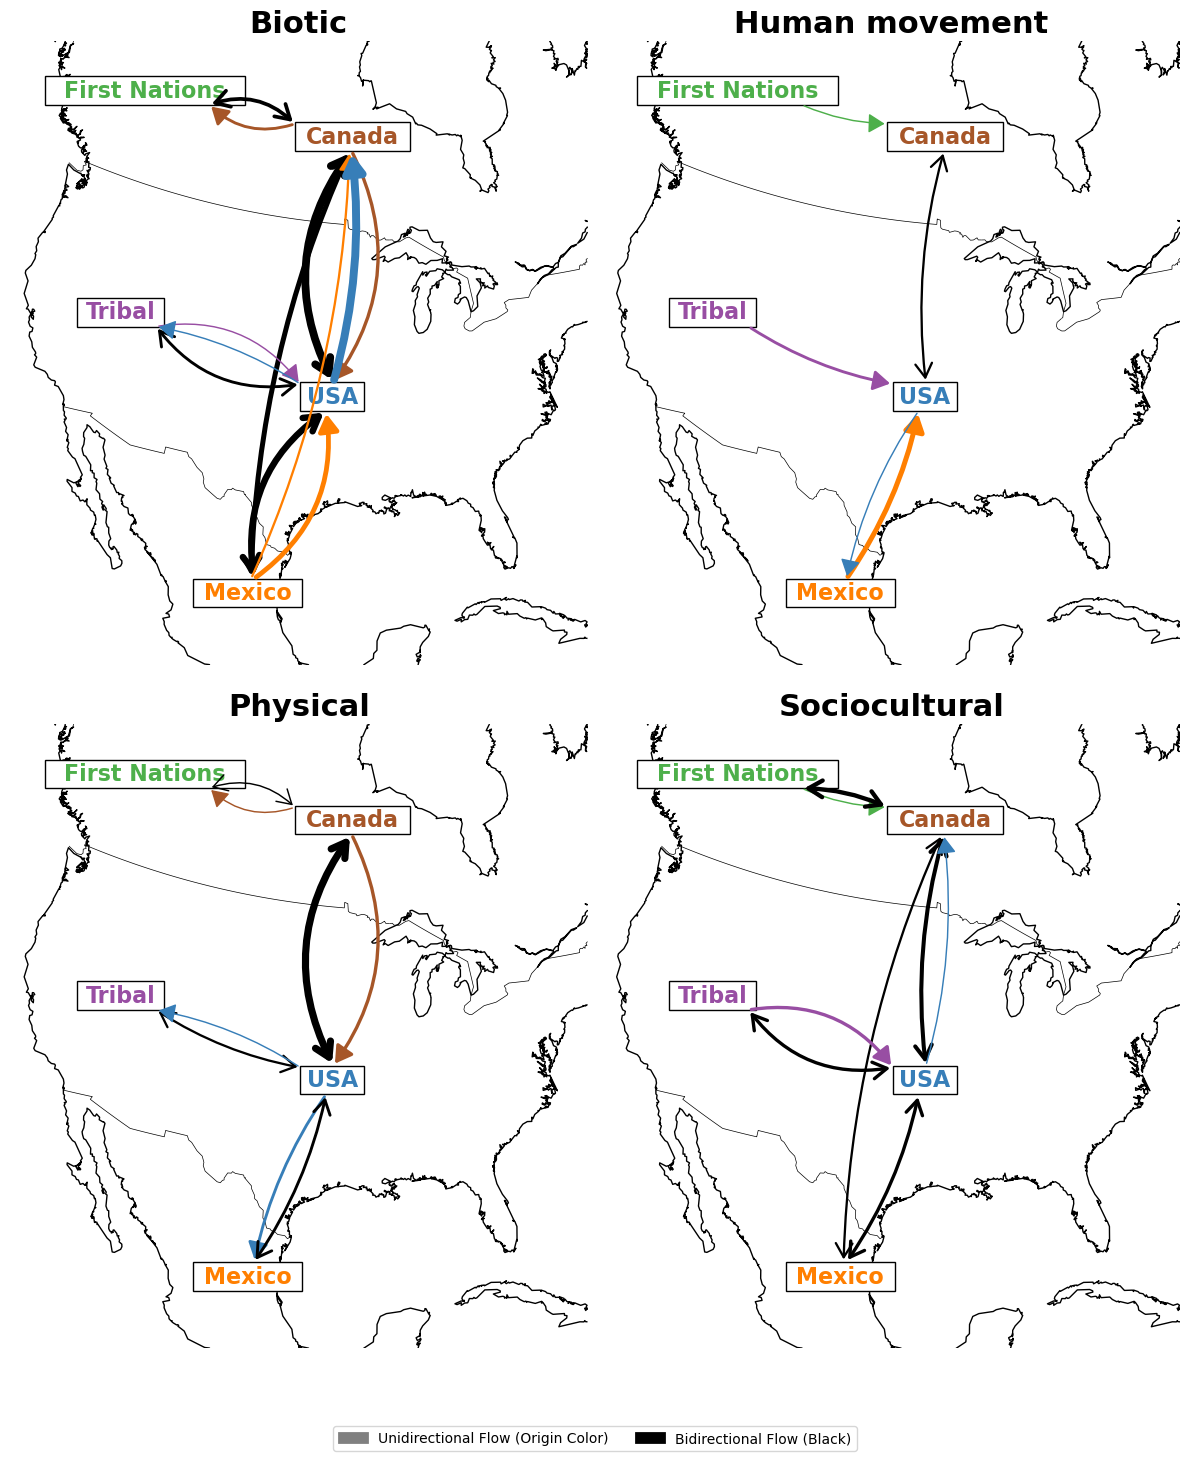

In [9]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch, Rectangle
from mpl_toolkits.basemap import Basemap
from collections import defaultdict
from itertools import combinations

flow_file = "path"

# Parameters for arrow appearance and layout
RADIUS = 300.0
ARROW_HEAD_LENGTH = 10
ARROW_HEAD_WIDTH  = 6

# custom coloring and labeling
location_colors = {
    "USA": "#377eb8",         
    "CAN": "#a65628",         
    "MEX": "#ff7f00",         
    "TRIBAL": "#984ea3",      
    "FIRST PEOPLES": "#4daf4a"
}

rename_labels = {
    "USA": "USA",
    "CAN": "Canada",
    "MEX": "Mexico",
    "TRIBAL": "Tribal",
    "FIRST PEOPLES": "First Nations"
}

location_centroids = {
    "USA": (37, -95),
    "CAN": (55, -95),
    "MEX": (23, -100),
    "TRIBAL": (40, -115),
    "FIRST PEOPLES": (55, -120),
}

# Load dataset 
df = pd.read_csv(flow_file)

# Group and summarize flow data by type
grouped = df.groupby(["Flow", "Flow_Type"], as_index=False)["Count"].sum()
flow_types = sorted(grouped["Flow_Type"].unique())[:4]

# Parse directional and bidirectional flows into standardized format
parsed_map = defaultdict(int)
for _, row in grouped.iterrows():
    ftype = row["Flow_Type"]
    if ftype not in flow_types:
        continue
    flow_str = row["Flow"]
    count = row["Count"]
    
    if " <-> " in flow_str:
        parts = flow_str.split(" <-> ")
        valid_pts = [p for p in parts if p in location_centroids]
        if len(valid_pts) >= 2:
            for (p1, p2) in combinations(valid_pts, 2):
                if p1 != p2:
                    pair = tuple(sorted([p1, p2]))
                    parsed_map[(ftype, True, pair)] += count
    elif " -> " in flow_str:
        parts = flow_str.split(" -> ")
        valid_pts = [p for p in parts if p in location_centroids]
        if len(valid_pts) >= 2:
            for (p1, p2) in combinations(valid_pts, 2):
                if p1 != p2:
                    parsed_map[(ftype, False, (p1, p2))] += count

# Organize flow records for plotting
final_flows_by_type = defaultdict(list)
for (flow_type, is_bi, pair), total_cnt in parsed_map.items():
    if flow_type not in flow_types:
        continue
    org, dst = pair
    final_flows_by_type[flow_type].append({
        "Origin": org,
        "Destination": dst,
        "Count": total_cnt,
        "IsBidirectional": is_bi
    })

# Create a  basemap using Basemap package
def create_basemap(ax):
    m = Basemap(
        projection="lcc",
        resolution="l",
        area_thresh=100000.,
        lat_0=40, lon_0=-88,
        llcrnrlat=15, urcrnrlat=60,
        llcrnrlon=-115, urcrnrlon=-65,
        ax=ax
    )
    m.drawcoastlines()
    m.drawcountries()
    m.fillcontinents(color="white")
    m.drawmapboundary(fill_color="white")
    return m

# Spread out arrow endpoints around each region's centroid
def assign_offsets(flows, radius, m):
    inbound_map = defaultdict(list)
    outbound_map = defaultdict(list)
    for i, rec in enumerate(flows):
        inbound_map[rec["Destination"]].append(i)
        outbound_map[rec["Origin"]].append(i)

    inbound_off, outbound_off = {}, {}
    for region, idx_list in inbound_map.items():
        latC, lonC = location_centroids[region]
        xC, yC = m(lonC, latC)
        idx_list.sort()
        n_in = len(idx_list)
        inbound_off[region] = {}
        for k, flow_idx in enumerate(idx_list):
            angle = 2 * math.pi * (k + 0.5) / n_in
            xOff = xC + radius * math.cos(angle)
            yOff = yC + radius * math.sin(angle)
            inbound_off[region][flow_idx] = (xOff, yOff)

    for region, idx_list in outbound_map.items():
        latC, lonC = location_centroids[region]
        xC, yC = m(lonC, latC)
        idx_list.sort()
        n_out = len(idx_list)
        outbound_off[region] = {}
        for k, flow_idx in enumerate(idx_list):
            angle = 2 * math.pi * (k + 0.5) / n_out
            xOff = xC + radius * math.cos(angle)
            yOff = yC + radius * math.sin(angle)
            outbound_off[region][flow_idx] = (xOff, yOff)

    return inbound_off, outbound_off

# Spread overlapping arrows between the same regions using arc curvature
def distribute_arcs(flows):
    od_map = defaultdict(list)
    for i, rec in enumerate(flows):
        od_map[(rec["Origin"], rec["Destination"])].append(i)
    arc_map = {}
    for (org, dst), idx_list in od_map.items():
        idx_list.sort()
        n_arrows = len(idx_list)
        base_arc = 0.3 + 0.05 * (n_arrows - 4) if n_arrows > 4 else 0.3
        base_arc = min(base_arc, 0.5)
        if n_arrows == 1:
            arc_map[idx_list[0]] = 0.1
        else:
            step = (base_arc * 2) / (n_arrows - 1)
            val = -base_arc
            arcs = []
            for _ in range(n_arrows):
                arcs.append(val)
                val += step
            for j, arrow_idx in enumerate(idx_list):
                arc_map[arrow_idx] = arcs[j]
    return arc_map

# Measure text label sizes before drawing so arrows don’t overlap them
def measure_text_boxes(ax, label_info):
    text_objs = {}
    for loc, (x_data, y_data, txt, col) in label_info.items():
        t = ax.text(x_data, y_data, txt, fontsize=16, fontweight="bold", color=col, ha="center", va="center", alpha=0.0, zorder=6)
        text_objs[loc] = t

    ax.figure.canvas.draw()
    label_boxes = {}
    for loc, t in text_objs.items():
        bbox_disp = t.get_window_extent(renderer=ax.figure.canvas.get_renderer())
        inv = ax.transData.inverted()
        bbox_data = bbox_disp.transformed(inv)
        label_boxes[loc] = (bbox_data.x0, bbox_data.y0, bbox_data.x1, bbox_data.y1)
        t.remove()
    return label_boxes

# Find the intersection point of a line with a text box border
def line_rect_intersect(x_s, y_s, x_c, y_c, left, bottom, right, top):
    dx = x_c - x_s
    dy = y_c - y_s
    dist = math.hypot(dx, dy)
    if dist < 1e-9:
        return (x_c, y_c)
    solutions = []
    def check_x(x_edge):
        if abs(dx) < 1e-9: return
        t = (x_edge - x_s) / dx
        if 0 <= t <= 1:
            yint = y_s + t * dy
            if bottom - 1e-9 <= yint <= top + 1e-9:
                solutions.append((t, x_edge, yint))
    def check_y(y_edge):
        if abs(dy) < 1e-9: return
        t = (y_edge - y_s) / dy
        if 0 <= t <= 1:
            xint = x_s + t * dx
            if left - 1e-9 <= xint <= right + 1e-9:
                solutions.append((t, xint, y_edge))
    check_x(left); check_x(right); check_y(bottom); check_y(top)
    if not solutions:
        return (x_c, y_c)
    solutions.sort(key=lambda s: s[0])
    return (solutions[0][1], solutions[0][2])

# Draw the curved arrow between origin and destination
def draw_arrow_box(ax, x_start, y_start, rect, color, is_bi, count, arc, org_rect=None):
    lw = np.log1p(count) * 1.5
    arrow_style = "<->" if is_bi else "-|>"
    arrow_col = "black" if is_bi else color
    left, bottom, right, top = rect
    x_c, y_c = (left + right) * 0.5, (bottom + top) * 0.5
    x_end, y_end = line_rect_intersect(x_start, y_start, x_c, y_c, left, bottom, right, top)
    if org_rect:
        left_o, bottom_o, right_o, top_o = org_rect
        x_o, y_o = (left_o + right_o) * 0.5, (bottom_o + top_o) * 0.5
        x_start, y_start = line_rect_intersect(x_end, y_end, x_o, y_o, left_o, bottom_o, right_o, top_o)
    arr = FancyArrowPatch((x_start, y_start), (x_end, y_end), connectionstyle=f"arc3,rad={arc}",
                          arrowstyle=f"{arrow_style},head_length={ARROW_HEAD_LENGTH},head_width={ARROW_HEAD_WIDTH}",
                          lw=lw, color=arrow_col, alpha=1.0, zorder=10)
    ax.add_patch(arr)

# Draw the final rectangle label box with region name
def draw_final_label(ax, rect, txt, color):
    left, bottom, right, top = rect
    w, h = right - left, top - bottom
    rect_patch = Rectangle((left, bottom), w, h, facecolor="white", edgecolor="black", lw=1, alpha=1.0, zorder=5)
    ax.add_patch(rect_patch)
    cx, cy = (left + right) * 0.5, (bottom + top) * 0.5
    ax.text(cx, cy, txt, fontsize=16, fontweight="bold", color=color, ha="center", va="center", zorder=6)

# Main function to render the flow maps
def main():
    n_types = len(flow_types)
    ncols = 2
    nrows = math.ceil(n_types / ncols)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 7 * nrows))
    axes = np.array(axes).reshape(-1)
    plt.subplots_adjust(wspace=0.00, hspace=0.00)
    fig_idx = 0
    for ftype in flow_types:
        if ftype not in final_flows_by_type:
            continue
        ax = axes[fig_idx]
        ax.set_title(ftype, fontsize=22, fontweight="bold")
        fig_idx += 1
        m = create_basemap(ax)
        flows = final_flows_by_type[ftype]
        inbound_off, outbound_off = assign_offsets(flows, RADIUS, m)
        arc_map = distribute_arcs(flows)
        label_info = {}
        for loc, (lat, lon) in location_centroids.items():
            xlbl, ylbl = m(lon, lat)
            color_loc = location_colors.get(loc, "gray")
            txt = rename_labels.get(loc, loc)
            label_info[loc] = (xlbl, ylbl, txt, color_loc)
        label_boxes = measure_text_boxes(ax, label_info)
        for i, rec in enumerate(flows):
            org = rec["Origin"]
            dst = rec["Destination"]
            cnt = rec["Count"]
            is_bi = rec["IsBidirectional"]
            if dst not in inbound_off or i not in inbound_off[dst]: continue
            if org not in outbound_off or i not in outbound_off[org]: continue
            x0, y0 = outbound_off[org][i]
            arc = arc_map.get(i, 0.1)
            arrow_col = location_colors.get(org, "gray")
            dst_rect = label_boxes[dst]
            org_rect = label_boxes[org]
            draw_arrow_box(ax, x0, y0, dst_rect, arrow_col, is_bi, cnt, arc, org_rect=org_rect)
        for loc, rect in label_boxes.items():
            draw_final_label(ax, rect, rename_labels.get(loc, loc), location_colors.get(loc, "gray"))
        ax.axis("off")
    while fig_idx < len(axes):
        axes[fig_idx].axis("off")
        fig_idx += 1
    uni_leg = FancyArrowPatch((0, 0), (1, 0), arrowstyle=f"-|>,head_length={ARROW_HEAD_LENGTH},head_width={ARROW_HEAD_WIDTH}", color="gray", lw=2)
    bi_leg = FancyArrowPatch((0, 0), (1, 0), arrowstyle=f"<->,head_length={ARROW_HEAD_LENGTH},head_width={ARROW_HEAD_WIDTH}", color="black", lw=2)
    fig.legend(handles=[uni_leg, bi_leg], labels=["Unidirectional Flow (Origin Color)", "Bidirectional Flow (Black)"], loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.05))
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.savefig("path", dpi=300, bbox_inches="tight")
    plt.show()

if __name__ == "__main__":
    main()
